In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 # 특성으로 사용할 단어의 수
max_len = 500 # 사용할 텍스트의 길이

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

print(len(x_train), len(x_test))

x_train = sequence.pad_sequences(x_train, maxlen = max_len)
x_test = sequence.pad_sequences(x_test, maxlen = max_len)
print(x_train.shape, x_test.shape)

Using TensorFlow backend.


17465344/17464789 [==============================] - 1s 0us/step
25000 25000
(25000, 500) (25000, 500)


In [4]:
# 2d와 다른 건 2d는 3 * 3 이런 식으로 썼는데 여기서는 7 이런 식도 가능
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length = max_len))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(lr = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
________________________________________

In [0]:
# 단어 수준 감성 분류 작업은 1d가 더 효율적임
# LSTM보다는 낮음

In [0]:
import matplotlib.pyplot as plt

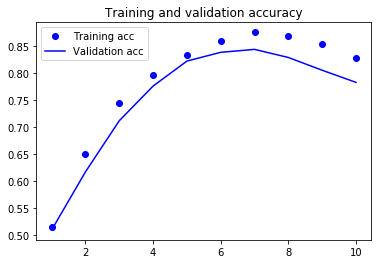

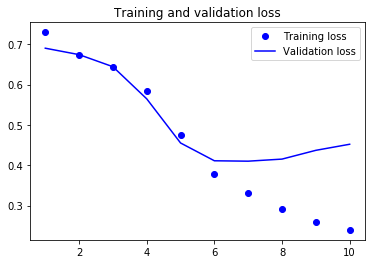

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 온도문제에 이걸 써보자.
import os
import numpy as np

data_dir = '/content/drive/My Drive/dataset/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = 'relu',
                        input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 17s 34ms/step - loss: 0.4190 - val_loss: 0.4470
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3654 - val_loss: 0.4560
Epoch 3/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3441 - val_loss: 0.4513
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3278 - val_loss: 0.4709
Epoch 5/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3117 - val_loss: 0.4449
Epoch 6/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3004 - val_loss: 0.4801
Epoch 7/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2944 - val_loss: 0.4699
Epoch 8/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2847 - val_loss: 0.4811
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2806 - val_loss: 0.4799
Epoch 10/20
500/500 [==============================] - 16s 33ms/step - loss: 0.273

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

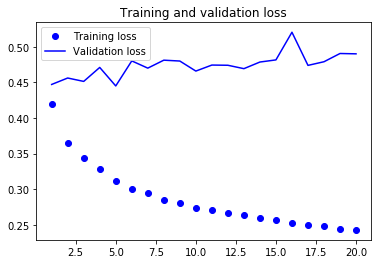

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 많이 못 올라가는 이유는 작은 conv net으 써서 상식 수준의 기준점을 넘지 못했음
# 입력 시계열의 패턴을 시간축이라고 고려하지 않아서

# conv net을 rnn 처리 전 전처리 단계로 사용을 하면 어떻게 될까?
# conv net이 긴 입력 시퀀스를 더 짧은 고수준으로 바꿔준다.

In [0]:
# 이전에는 6이었습니다(시간마다 1 포인트); 이제는 3 입니다(30분마다 1 포인트)
step = 3
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [0]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation = 'relu',
                        input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
# 위랑 다른 건 globalmaxpooling1d 대신 gru 넣음
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 규제 있는 GRU보다 좋진 않지만 빠르게 처리할 수 있음

In [3]:
import time

print('start')

for second in range(0,5) :
  print(second)
  time.sleep(second)

print('end')

start
0
1
2
3
4
end


In [4]:
import time

print('start')

for second in range(0,5) :
  print(second, flush = True)
  time.sleep(second)

print('end')

start
0
1
2
3
4
end
